#**MNIST CNN Model!**

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
%matplotlib inline

## **Data Collection & Processing**

In [56]:
transform = transforms.ToTensor()

In [57]:
train_data = datasets.MNIST(root = "data", train = True, transform = transform, download = True)
test_data = datasets.MNIST(root = "data", train = False, transform = transform, download = True)

In [58]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

## **Creating the CNN Model!**

In [59]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def feedForward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16 * 5 * 5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim = 1)

In [60]:
torch.manual_seed(17)

In [61]:
model = CNN()

In [62]:
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## **Training the Model**

In [63]:
criterion = nn.CrossEntropyLoss()

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [65]:
import time

start_time = time.time()

# Variables To Track.......
epochs : int = 5
train_losses : list = []
test_losses : list = []
train_correct : list = []
test_correct : list = []

i : int = 1
while i <= epochs:
  train_corr : int = 0
  test_corr : int = 0

  #Training
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model.feedForward(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr : int = (predicted == y_train).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b + 1) % 100 == 0:
      print(f"Epoch : {i}, Batch : {b + 1}, Loss : {loss.item()}")

  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model.feedForward(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

  i += 1

current_time = time.time()
print(f"Training took {current_time - start_time} seconds!")

Epoch : 1, Batch : 100, Loss : 0.9118455052375793
Epoch : 1, Batch : 200, Loss : 0.8940961956977844
Epoch : 1, Batch : 300, Loss : 0.3444124460220337
Epoch : 1, Batch : 400, Loss : 0.3172015845775604
Epoch : 1, Batch : 500, Loss : 0.07117006182670593
Epoch : 1, Batch : 600, Loss : 0.031465739011764526
Epoch : 1, Batch : 700, Loss : 0.40989232063293457
Epoch : 1, Batch : 800, Loss : 0.19670596718788147
Epoch : 1, Batch : 900, Loss : 0.317547082901001
Epoch : 1, Batch : 1000, Loss : 0.41231268644332886
Epoch : 1, Batch : 1100, Loss : 0.2926010489463806
Epoch : 1, Batch : 1200, Loss : 0.03347271680831909
Epoch : 1, Batch : 1300, Loss : 0.22453586757183075
Epoch : 1, Batch : 1400, Loss : 0.015044452622532845
Epoch : 1, Batch : 1500, Loss : 0.014532877132296562
Epoch : 1, Batch : 1600, Loss : 0.24592642486095428
Epoch : 1, Batch : 1700, Loss : 0.2576756477355957
Epoch : 1, Batch : 1800, Loss : 0.040100596845149994
Epoch : 1, Batch : 1900, Loss : 0.2341555655002594
Epoch : 1, Batch : 2000, L

## **Plotting the results**

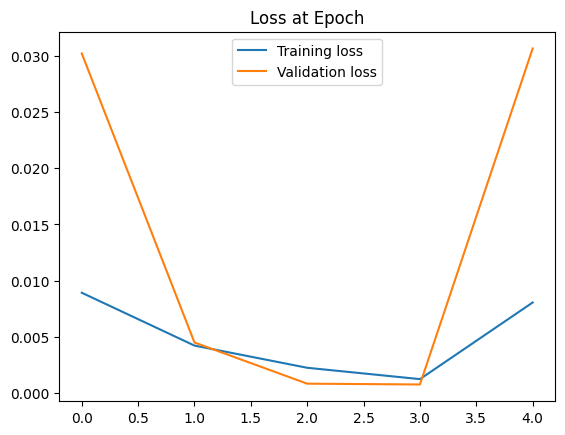

In [66]:
# plotting the results
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.title("Loss at Epoch")
plt.legend()

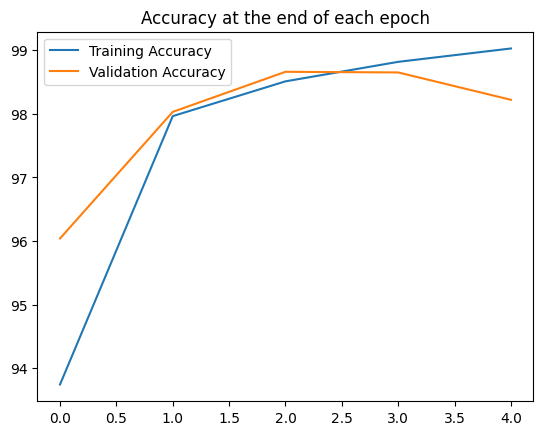

In [67]:
plt.plot([t / 600 for t in train_correct], label = "Training Accuracy")
plt.plot([t / 100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

##**Finding the Accuracy!**

In [68]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in DataLoader(test_data, batch_size = 10000, shuffle = False):
    y_pred = model.feedForward(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct += (predicted == y_test).sum()

In [69]:
# Accuracy
print(f"Accuracy : {correct.item() / len(test_data) * 100}%")

Accuracy : 98.22%


##**Testing using an image**

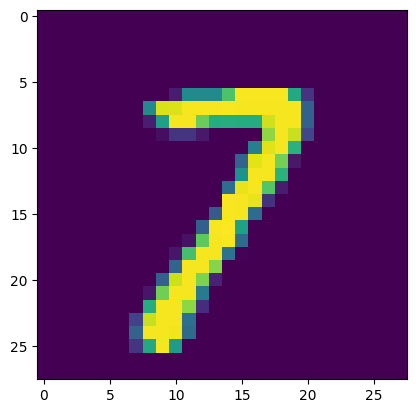

In [70]:
plt.imshow(test_data[1117][0].reshape(28,28))

In [71]:
model.eval()
with torch.no_grad():
  prediction = model.feedForward(test_data[1117][0].view(1, 1, 28, 28))

In [72]:
print(f"The number shown above is {prediction.argmax()}")

The number shown above is 7


##**Saving the model**

In [73]:
torch.save(model.state_dict(), "MNIST_CNN_Model.pt")